In [1]:
import glob
import os
import re
import shutil
import random
import string
import sys

import numpy as np
import pandas as pd

import nilearn
from nilearn import plotting, image
from nilearn.input_data import NiftiMasker
import nibabel as nib
from nipype.interfaces import ants
import nighres

import subprocess
import json
import multiprocessing as mp
from functools import partial
import joblib
from joblib import Parallel, delayed
import itertools
from utils import apply_warp

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


# 1. Warp ATAG masks to T1w space
We have all masks in MNI2009cAsym 1 mm space; hence, applying the composite warp to T1w and then the affine to functional data.

These masks are from ATAG, Harvard-Oxford, combined with a binary preSMA mask (based on coordinates from Johannsen-Berg), the VTA masks from Anne and the recently published LC masks. Ie, they're a pot-pourri, useful for checking things

In [ ]:
all_subjects = [x.split('/')[-2].split('-')[-1] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub*/ses-anatomical'))]
# all_subjects = ['002','003','004','005','006','007','008','009','010','011']
# all_subjects = ['012','013','014','015','016']
# all_subjects = ['017','018','019','020','021']
# all_subjects = ['022','023','024','025','026']
# all_subjects = ['027','029','030','031','032']
# all_subjects = ['043','044']

def warp_masks_2_t1w(sub, overwrite=True):
    print(sub)
    #match re all probabily masks
    regex_masks = re.compile('.*/space-MNI152NLin2009cAsym_label-(?P<label>\S+)_probseg.nii.gz')
    #get all masks
    all_masks = sorted(glob.glob('../sourcedata/masks/MNI152NLin2009cAsym/*.nii.gz'))
    #output image name
    output_img_base = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{label}}.nii.gz'
    
    for mask in all_masks:
        #get mask label
        mask_label = regex_masks.match(mask).groupdict()['label']
        #create filename
        final_img_fn = output_img_base.format(label=mask_label)
        #if the path doesn't exist or if we want to overwrite
        if not os.path.exists(final_img_fn) or overwrite:
            #create the file/folders
            os.makedirs(os.path.dirname(final_img_fn), exist_ok=True)
            #warp from MNI to T1w
            tmp_img_name = apply_warp(mask, sub=sub, t1w_to_MNI=False)
            #move file to final destination
            shutil.move(tmp_img_name, final_img_fn)

#run function for all subjects
_ = [warp_masks_2_t1w(x) for x in all_subjects]

#or in parallel
with mp.Pool(20) as p:
    p.map(warp_masks_2_t1w, all_subjects)
    
# warp_masks_2_t1w('042')

# 2. Downsample MASSP masks to functional resolution

Pilou runs MASSP using the multimodal anatomical qMRI data, which outputs binary masks in T1w-space / resolution *(plus posteriors, what to do with these?)*. For analyses of functional data, we need to downsample these. Here, we use linear interpolation.

MASSP 2.0 labels

    Label : Structure name : Acronym : Hemisphere
    1 : Caudate : cau : l
    2 : Caudate : cau : r
    3 : Subthalamic nucleus : stn : l
    4 : Subthalamic nucleus : stn : r
    5 : Substantia nigra : sn : l
    6 : Substantia nigra : sn : r
    7 : Red nucleus : rn : l
    8 : Red nucleus : rn : r
    9 : Globus pallidus pars interna : gpi : l
    10 : Globus pallidus pars interna : gpi : r
    11 : Globus pallidus pars externa : gpe : l
    12 : Globus pallidus pars externa : gpe : r
    13 : Thalamus : tha : l
    14 : Thalamus : tha : r
    15 : Lateral ventricle : vent : l
    16 : Lateral ventricle : vent : r
    17 : Third ventricle : vent : 3
    18 : Fourth ventricle : vent : 4
    19 : Amygdala : amg : l
    20 : Amygdala : amg : r
    21 : Internal capsule : ic : l
    22 : Internal capsule : ic : r
    23 : Ventral tegmental area : vta : l
    24 : Ventral tegmental area : vta : r
    25 : Fornix : fx : lr
    26 : Periaqueductal gray : pag : l
    27 : Periaqueductal gray : pag : r
    28 : Pedunculopontine nucleus : ppn : l
    29 : Pedunculopontine nucleus : ppn : r
    30 : Claustrum : cl : l
    31 : Claustrum : cl : r
    32 : Inferior colliculus : ico : l
    33 : Inferior colliculus : ico : r
    34 : Superior colliculus : sco : l
    35 : Superior colliculus : sco : r
    36 : Lateral habenula : lh : l
    37 : Lateral habenula : lh : r
    38 : Putamen : put : l
    39 : Putamen : put : r
    40 : Accumbens : acc : l
    41 : Accumbens : acc : r
    42 : Cornu ammonis 1 : ca1 : l
    43 : Cornu ammonis 1 : ca1 : r
    44 : Cornu ammonis 2,3 : ca23 : l
    45 : Cornu ammonis 2,3 : ca23 : r
    46 : Dentate gyrus : dg : l
    47 : Dentate gyrus : dg : r
    48 : Pre/pro subiculum : presub : l
    49 : Pre/pro subiculum : presub : r
    50 : Subiculum : sub : l
    51 : Subiculum : sub : r
    52 : Uncus : unc : l
    53 : Uncus : unc : r
    54 : Anterior commissure : ac : lr
    55 : Posterior commissure : pc : lr
    56 : Cholinergic forebrain nuclei : chn : l
    57 : Cholinergic forebrain nuclei : chn : r
    58:  Dorsal raphe nucleus : drn : lr
    59 : Medial raphe nucleus : mrn : lr
    60 : Lateral geniculate nucleus : lgn : l
    61 : Lateral geniculate nucleus : lgn : r
    62 : Medial geniculate nucleus : mgn : l
    63 : Medial geniculate nucleus : mgn : r

In [9]:
# def warp_massp_map(args, atlas, target_img):
#     label_n, label = args
#     random.seed(label_n)
#     this_map = atlas.get_fdata().copy()
#     this_map[this_map!=(label_n+1)] = 0
#     this_map[this_map>0] = 1
#     this_map_nii = nib.Nifti1Image(this_map, atlas.affine)

#     # ok now we need to do this rather annoying temporary save thing agian
#     tmp_name = './tmp_img_to_warp-{}.nii.gz'.format(''.join(random.choices(string.ascii_letters + string.digits, k=10)))
#     this_map_nii.to_filename(tmp_name)

#     out = nighres.registration.embedded_antsreg(source_image=tmp_name, 
#                                                 target_image=target_img,
#                                                 run_rigid=True, rigid_iterations=0, 
#                                                 run_affine=False, run_syn=False, overwrite=True, 
#                                                 interpolation='Linear', save_data=True, output_dir='./', file_name=f'{tmp_name}_warp.nii.gz')
#     warped_img = out['transformed_sources'][0]
#     warped_data = warped_img.get_fdata()

#     # clean-up
#     os.remove(tmp_name)
#     os.remove(f'{tmp_name}_warp_ants-def0.nii.gz')
#     os.remove(f'{tmp_name}_warp_ants-map.nii.gz')
#     os.remove(f'{tmp_name}_warp_ants-invmap.nii.gz')
#     return {label: nib.Nifti1Image(warped_data.copy(), header=warped_img.header, affine=warped_img.affine)}

def warp_massp_map(args, atlas, target_img):
    label_n, label = args
    this_map = atlas.get_fdata().copy()
    this_map[this_map!=(label_n+1)] = 0
    this_map[this_map>0] = 1
    this_map_nii = nib.Nifti1Image(this_map, atlas.affine)

    # ok now we need to do this rather annoying temporary save thing agian. Note that we use linear interpolation (the masks are binary now, so linear interpolation gives us a partial volume estimate which can then be used for weighing later on)
    resampled_img = nilearn.image.resample_to_img(source_img=this_map_nii, target_img=target_img, interpolation='linear')
    return {label: resampled_img}

def load_MASSP_atlas_1p5mm(sub,overwrite=True): 
    labels_17structures = ['Str-l','Str-r','STN-l','STN-r','SN-l','SN-r',\
                           'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
                           'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
                           'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
                           'PPN-l','PPN-r','Cl-l','Cl-r']

    # save fns
    save_fn_template = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{}}.nii.gz'
    if os.path.exists(save_fn_template.format('Str-l')) and not overwrite:
        # Already warped, load atlas
        maps = {}
        for label in labels_17structures:
            maps[label] = nib.load(save_fn_template.format(label))
        
    else:
        atlas_fn = os.path.join('..', 'derivatives', 'nighres', f'sub-{sub}', 'ses-anatomical', 'subcortex', f'sub-{sub}_ses-anatomical_massp-labels.nii.gz')
        if not os.path.exists(atlas_fn):
            print(f'MASSP not yet run for sub-{sub} (returning 0 to prevent break)')
            return 0
        target_img = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        atlas = nib.load(atlas_fn)

        # now we need to reduce resolution to 1.5mm
        with mp.Pool(32) as p:
            maps = p.map(partial(warp_massp_map, atlas=atlas, target_img=target_img), enumerate(labels_17structures))
        maps = {list(x.keys())[0]: list(x.values())[0] for x in maps}
        
        # save
        os.makedirs(os.path.dirname(save_fn_template), exist_ok=True)
        for label in labels_17structures:
            maps[label].to_filename(save_fn_template.format(label))

    return maps



# Updated MASSP atlas: since Oct 2023 
# labels here: https://github.com/nighres/nighres/blob/master/nighres/parcellation/massp-label-list.txt
def load_MASSP27_atlas_1p5mm(sub,overwrite=True): 
    labels_27structures = ['Str-l','Str-r','STN-l','STN-r','SN-l','SN-r',\
                           'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
                           'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
                           'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
                           'PPN-l','PPN-r','Cl-l','Cl-r', 'ICo-l', 'ICo-r', \
                           'SCo-l', 'SCo-r', 'LH-l', 'LH-r', 'AC-lr', 'PC-lr', \
                           'Chn-l', 'Chn-r', 'DRN-lr', 'MRN-lr', 'RMg-lr', 'RPo-lr']

    # save fns
    save_fn_template = f'../derivatives/masks_massp27_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{}}.nii.gz'
    if os.path.exists(save_fn_template.format('Str-l')) and not overwrite:
        # Already warped, load atlas
        maps = {}
        for label in labels_27structures:
            maps[label] = nib.load(save_fn_template.format(label))
        
    else:
        atlas_fn = os.path.join('..', 'derivatives', 'nighres', f'sub-{sub}', 'ses-anatomical', 'subcortex', f'sub-{sub}_ses-anatomical_massp27-labels.nii.gz')
        if not os.path.exists(atlas_fn):
            print(f'MASSP not yet run for sub-{sub} (returning 0 to prevent break)')
            return 0
        target_img = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        atlas = nib.load(atlas_fn)

        # now we need to reduce resolution to 1.5mm
        with mp.Pool(32) as p:
            maps = p.map(partial(warp_massp_map, atlas=atlas, target_img=target_img), enumerate(labels_27structures))
        maps = {list(x.keys())[0]: list(x.values())[0] for x in maps}
        
        # save
        os.makedirs(os.path.dirname(save_fn_template), exist_ok=True)
        for label in labels_27structures:
            maps[label].to_filename(save_fn_template.format(label))

    return maps



# Updated MASSP atlas: since Aug 2024 
# Pilou recommends using massp_2p0mni labels, which seem to gain something from being processed at higher resolution.

def load_MASSP2p0_atlas_1p5mm(sub,overwrite=False): 
    labels_27structures = ['Cau-l','Cau-r','STN-l','STN-r','SN-l','SN-r',\
                           'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
                           'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
                           'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
                           'PPN-l','PPN-r','Cl-l','Cl-r', 'ICo-l', 'ICo-r', \
                           'SCo-l', 'SCo-r', 'LH-l', 'LH-r', 'Pu-l', 'Pu-r', 'nAcc-l', 'nAcc-r',\
                           'Ca1-l', 'Ca1-r', 'Ca23-l', 'Ca23-r', 'Dg-l', 'Dg-r', \
                           'presub-l', 'presub-r', 'sub-l', 'sub-r', 'unc-l', 'unc-r',\
                           'AC-lr', 'PC-lr', 'Chn-l', 'Chn-r', 'DRN-lr', 'MRN-lr', 'LGN-l', 'LGN-r',\
                           'MGN-l', 'MGN-r'
                           ]

    # save fns
    save_fn_template = f'../derivatives/masks_massp2p0_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{}}.nii.gz'
    if os.path.exists(save_fn_template.format('STN-l')) and not overwrite:
        # Already warped, load atlas
        maps = {}
        for label in labels_27structures:
            maps[label] = nib.load(save_fn_template.format(label))
        
    else:
        atlas_fn = os.path.join('..', 'derivatives', 'nighres', f'sub-{sub}', 'ses-anatomical', 'subcortex', f'sub-{sub}_ses-anatomical_massp_2p0mni-labels.nii.gz')
        if not os.path.exists(atlas_fn):
            print(f'MASSP 2.0 not yet run for sub-{sub} (returning 0 to prevent break)')
            return 0
        target_img = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        atlas = nib.load(atlas_fn)

        # now we need to reduce resolution to 1.5mm
        with mp.Pool(32) as p:
            maps = p.map(partial(warp_massp_map, atlas=atlas, target_img=target_img), enumerate(labels_27structures))
        maps = {list(x.keys())[0]: list(x.values())[0] for x in maps}
        
        # save
        os.makedirs(os.path.dirname(save_fn_template), exist_ok=True)
        for label in labels_27structures:
            maps[label].to_filename(save_fn_template.format(label))

    return maps

In [3]:
# labels_27structures = ['Cau-l','Cau-r','STN-l','STN-r','SN-l','SN-r',\
#                            'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
#                            'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
#                            'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
#                            'PPN-l','PPN-r','Cl-l','Cl-r', 'ICo-l', 'ICo-r', \
#                            'SCo-l', 'SCo-r', 'LH-l', 'LH-r', 'Pu-l', 'Pu-r', 'nAcc-l', 'nAcc-r',\
#                            'Ca1-l', 'Ca1-r', 'Ca23-l', 'Ca23-r', 'Dg-l', 'Dg-r', \
#                            'presub-l', 'presub-r', 'sub-l', 'sub-r', 'unc-l', 'unc-r',\
#                            'AC-lr', 'PC-lr', \
#                            'Chn-l', 'Chn-r', 'DRN-lr', 'MRN-lr', 'LGN-l', 'LGN-r',\
#                            'MGN-l', 'MGN-r'
#                            ]

print(len(labels_27structures))

NameError: name 'labels_27structures' is not defined

In [ ]:
## SM: Warp masks of MASSP2p0 for RLSAT participants
import re
regex = re.compile('.*/sub-(?P<sub>\d+)/.*')
subs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-0*/ses-rlsat/'))
subs = [regex.match(x)['sub'] for x in subs]

for subject in subs:
    print(subject)
    load_MASSP2p0_atlas_1p5mm(subject, overwrite=False)
    
## END SM

002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
023
024


In [ ]:
[x.split('-')[1].split('.')[0] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*.html'))]

In [ ]:
subs_

In [ ]:
# check which subs have massps masks
# all_subjects_massp = [x.split('/')[3].split('-')[-1] for x in sorted(glob.glob('../derivatives/nighres/sub-*/ses-anatomical/subcortex/sub*_massp-labels.nii.gz'))]
# all_subjects_fmriprep = [x.split('-')[1].split('.')[0] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*.html'))]
# all_subjects = [x for x in all_subjects_massp if x in all_subjects_fmriprep]
# all_subjects = ['002','003','004','005','006','007','008','009','010','011']
# all_subjects = ['012','013','014','015','016']
# all_subjects = ['017','018','019','020','021']
# all_subjects = ['022','023','024','025','026']
# all_subjects = ['027','029','030','031','032']
#all_subjects = [x.split('-')[1].split('.')[0] for x in sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*.html'))]
# exclude subs that aren't fmriprepped yet
# all_subjects = ['043','044']
# all_subjects = ['026']

import warnings
warnings.filterwarnings("ignore")

subs_ = [s.split('-')[1] for s in [x.split('/')[3] for x in sorted(glob.glob('../derivatives/susan_smoothed_func/sub-*/ses-grids'))]]
#already_run = [s.split('-')[1] for s in [x.split('/')[4] for x in sorted(glob.glob('../derivatives/glm_feat/subject_level_model/sub-*/ses-rbrevl/func/fwhm-4p5/model-*/*task-rb*'))]]
# to_run = [x for x in subs_]
to_run = ['060']

for subject in to_run:
    print(subject)
    load_MASSP2p0_atlas_1p5mm(subject)

## 2b.  Downsample LC mask to functional resolution   
#### note: This applies only for subs who did Leiden task - where the MT-TFL scan was run.


In [ ]:
def warp_singular_map(atlas_img, target_img):
    this_map = atlas_img.get_fdata().copy()
    this_map[this_map>0] = 1
    this_map_nii = nib.Nifti1Image(this_map, atlas_img.affine)

    # ok now we need to do this rather annoying temporary save thing agian. Note that we use linear interpolation (the masks are binary now, so linear interpolation gives us a partial volume estimate which can then be used for weighing later on)
    resampled_img = nilearn.image.resample_to_img(source_img=this_map_nii, target_img=target_img, interpolation='linear')
    return resampled_img


def load_LC_mask_0p75mm(sub,overwrite=True): 
    
    # save fns
    save_fn = f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask{{}}.nii.gz'
    
    if os.path.exists(save_fn.format('-r')) and os.path.exists(save_fn.format('-l')) and not overwrite:
        maps = {}
        for label in labels_11subfields:
            maps[f"LC-l"] = nib.load(save_fn_template.format('-l'))
            maps[f"LC-r"] = nib.load(save_fn_template.format('-r'))
    else:
   
        atlas_fns = glob.glob(os.path.join('..', 'derivatives', 'mt_tfl', f'sub-{sub}', 'LC_mask_T1-w_space', f'sub-{sub}_LC_mask_T1-w_space_refined_*.nii'))
        
        if not atlas_fns:
            print(f'No LC mask for sub-{sub} (returning 0 to prevent break)')
            return 0
                      
        target_img = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-mrlc/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        
        maps = {}
        for hem_atlas in atlas_fns:

            hemisphere = '-l' if '_L.nii' in hem_atlas else '-r'  # Determine hemisphere based on filename
            atlas = nib.load(hem_atlas)

            # now we need to reduce resolution to 1.5mm
            LC_mask = warp_singular_map(atlas, target_img)
            filename = f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask-LC{hemisphere}.nii.gz'
            print(filename)
            LC_mask.to_filename(filename)  # Save the label map with appropriate filename
            maps[f"LC{hemisphere}"] = LC_mask  # Store in maps dictionary

    return maps



def refine_LC_mask_with_4V_vox(sub):
    # load in LC and 4V masks 
    mask_LC_r = nib.load(f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask-LC-r.nii.gz')
    mask_V4 = nib.load(f'../derivatives/masks_massp27_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-4V.nii.gz')
    
    # Get the data arrays
    mask_LC_r_data = mask_LC_r.get_fdata()
    mask_V4_data = mask_V4.get_fdata()
    
    # Right lc:-------------------------
    # Check for overlapping voxels
    overlap_voxs_r = np.logical_and(mask_LC_r_data > 0, mask_V4_data > 0)

    # Determine the mask with the highest probability for each overlapping voxel
    highest_prob_LC_r = np.where(mask_LC_r_data >= mask_V4_data, mask_LC_r_data, 0)
    highest_prob_V4_r = np.where(mask_V4_data > mask_LC_r_data, mask_V4_data, 0)

    # Create new masks based on the highest probabilities
    new_mask_LC_r_data = np.where(overlap_voxs_r, highest_prob_LC_r, mask_LC_r_data)
    new_mask_V4_data = np.where(overlap_voxs_r, highest_prob_V4_r, mask_V4_data)
    
    
    new_mask_LC_r_img = nib.Nifti1Image(new_mask_LC_r_data, affine=mask_LC_r.affine)
    #new_mask_V4_img = nib.Nifti1Image(new_mask_V4_data, affine=mask_V4.affine)
    
    nib.save(new_mask_LC_r_img, f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask-LC-r_V4_excl.nii.gz')
    #nib.save(new_mask_V4_img, f'../derivatives/masks_massp27_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-4V_LC_excl.nii.gz')
    
    
    
    # left lc:-------------------------
    mask_LC_l = nib.load(f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask-LC-l.nii.gz')
    mask_LC_l_data = mask_LC_l.get_fdata()
    
    # Check for overlapping voxels
    overlap_voxs_l = np.logical_and(mask_LC_l_data > 0, new_mask_V4_data > 0)

    # Determine the mask with the highest probability for each overlapping voxel
    highest_prob_LC_l = np.where(mask_LC_l_data >= new_mask_V4_data, mask_LC_l_data, 0)
    highest_prob_V4_l = np.where(new_mask_V4_data > mask_LC_l_data, new_mask_V4_data, 0)

    # Create new masks based on the highest probabilities
    new_mask_LC_l_data = np.where(overlap_voxs_l, highest_prob_LC_l, mask_LC_l_data)
    fin_mask_V4_data = np.where(overlap_voxs_l, highest_prob_V4_l, new_mask_V4_data)
    
    
    new_mask_LC_l_img = nib.Nifti1Image(new_mask_LC_l_data, affine=mask_LC_l.affine)
    fin_mask_V4_img = nib.Nifti1Image(fin_mask_V4_data, affine=mask_V4.affine)
    
    nib.save(new_mask_LC_l_img, f'../derivatives/mt_tfl/sub-{sub}/LC_mask_T1-w_space/sub-{sub}_LC_mask_space-T1w_desc-mask-LC-l_V4_excl.nii.gz')
    nib.save(fin_mask_V4_img, f'../derivatives/masks_massp27_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-4V_LC_excl.nii.gz')
    
    
    
    #overlap_voxs_l = np.logical_and(mask_LC_l > 0, mask_V4 > 0)

## 2c.  Downsample hippocampal subfield masks to functional resolution   
#### note: This applies only for subs who have had freesurfer hipp segmentation run: https://surfer.nmr.mgh.harvard.edu/fswiki/HippocampalSubfieldsAndNucleiOfAmygdala


In [ ]:
def warp_hippSubfield_map(args, atlas, target_img):
    label_n, label = args
    this_map = atlas.get_fdata().copy()
    this_map[this_map!=label_n] = 0
    this_map[this_map>0] = 1
    this_map_nii = nib.Nifti1Image(this_map, atlas.affine)

    # ok now we need to do this rather annoying temporary save thing agian. Note that we use continuous interpolation here after checking with original atlas: this works best
    resampled_img = nilearn.image.resample_to_img(source_img=this_map_nii, target_img=target_img, interpolation='linear')
    return {label: resampled_img}

def load_hippSubfield_atlas_0p75mm(sub, overwrite=True):
    print('running hipp downsampling')
    import multiprocessing as mp
    from functools import partial
    
    labels_11subfields = ['parasubiculum', 'presubiculum', 'subiculum', 'CA1', 'CA3', 'CA4', \
                           'GC-DG', 'HATA', 'fimbria', 'molecular_layer_HP', 'hippocampal_fissure']
    n_labels_11subfields = [203, 204, 205, 206, 208, 209, 210, 211, 212, 214, 215, 226]
    
    # Save filenames template
    save_fn_template = f'../derivatives/masks_hippSubfields_freesurfer/sub-{sub}/hipp_subFields_space_T1w-desc_func/sub-{sub}_space-T1w_desc-mask-{{}}-{{}}.nii.gz'
    
    if os.path.exists(save_fn_template.format('parasubiculum', 'l')) and \
       os.path.exists(save_fn_template.format('parasubiculum', 'r')) and \
       not overwrite:
        # Already warped, load atlas
        maps = {}
        for label in labels_11subfields:
            maps[f"{label}-l"] = nib.load(save_fn_template.format(label, 'l'))
            maps[f"{label}-r"] = nib.load(save_fn_template.format(label, 'r'))
    else:
        atlas_fns = glob.glob(f'/home/Public/trondheim/derivatives/masks_hippSubfields_freesurfer/sub-{sub}/hipp_subFields_space-T1w/*FS60.mgz')
        
        if not atlas_fns:
            print(f'Hipp subfields not yet run for sub-{sub} (returning 0 to prevent break)')
            return 0
        
        target_img = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[0]
        
        maps = {}
        for hem_atlas in atlas_fns:
            hemisphere = 'l' if 'lh' in hem_atlas else 'r'  # Determine hemisphere based on filename
            atlas = nib.load(hem_atlas)

            # Reduce resolution to 1.5mm
            with mp.Pool(32) as p:
                mapped_labels = p.map(partial(warp_hippSubfield_map, atlas=atlas, target_img=target_img), zip(n_labels_11subfields, labels_11subfields))
            
            for label_map in mapped_labels:
                label_key, label_value = list(label_map.items())[0]  # Extract key-value pair
                filename = f'../derivatives/masks_hippSubfields_freesurfer/sub-{sub}/hipp_subFields_space_T1w-desc_func/sub-{sub}_space-T1w_desc-mask-{label_key}-{hemisphere}.nii.gz'
                label_value.to_filename(filename)  # Save the label map with appropriate filename
                maps[f"{label_key}-{hemisphere}"] = label_value  # Store in maps dictionary

    return maps

In [ ]:
# # Ignore!!

# def move_hipp_files(sub):
#     # move freesurfer files 
#     import glob
#     import shutil

#     # Source and destination folders
#     source_folder = f'/home/Public/trondheim/derivatives/fmriprep/freesurfer/sub-{sub}/mri'
#     destination_folder = f'/home/Public/trondheim/derivatives/masks_hippSubfields_freesurfer/sub-{sub}/hipp_subFields_space-T1w'

#     # Pattern to match files
#     file_pattern = '*hippoAmygLabels-T1.v21.FS60.mgz'  # For example, to match all text files

#     # Get a list of files matching the pattern in the source folder
#     files_to_move = glob.glob(source_folder + '/' + file_pattern)
    
#     if not os.path.exists(destination_folder):
#         os.makedirs(destination_folder)
    
#     # Move each file to the destination folder
#     for file_path in files_to_move:
#         # Get the file name
#         file_name = file_path.split('/')[-1]

#         # Construct the destination file path
#         destination_file_path = destination_folder + '/' + file_name
#         # Move the file
#         shutil.copy(file_path, destination_file_path)

#     print("Files moved successfully.")
    
# def del_hipp(sub):
    

In [ ]:
#mrlc 
# which subs can we run?
subs_ = [s.split('-')[1] for s in [x.split('/')[3] for x in sorted(glob.glob('../derivatives/susan_smoothed_func/sub-*/ses-mrlc'))]]
#already_run = [s.split('-')[1] for s in [x.split('/')[4] for x in sorted(glob.glob('../derivatives/glm_feat/subject_level_model/sub-*/ses-rbrevl/func/fwhm-4p5/model-*/*task-rb*'))]]
to_run = [x for x in subs_]
#to_run = [x for x in subs_ if x not in excl_total]

for sub in to_run:
    refine_LC_mask_with_4V_vox(sub)

## plotting & checking

In [ ]:
def find_rois(sub, atlas_name='ATAG', space='T1w'):
    if atlas_name == 'ATAG':
        if space == 'MNI152NLin2009cAsym' or space == 'mni':
            ### Rois in MNI09c-space
            mask_dir='/home/Public/trondheim/sourcedata/masks/MNI152NLin2009cAsym_res-1p5'
            fns = sorted(glob.glob(mask_dir + '/space-*'))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_res-1p5_label-(?P<label>[a-zA-Z0-9]+)_probseg_def-img.nii.gz', fn).groupdict()['label'] for fn in fns]
        else:
            mask_dir = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
            fns = sorted(glob.glob(mask_dir))
            names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>[a-zA-Z0-9]+).nii.gz', fn).groupdict()['label'] for fn in fns]
    elif atlas_name == 'MASSP':
        mask_dir = f'../derivatives/masks_massp_func/sub-{sub}/anat/sub-{sub}_*.nii.gz'
        fns = sorted(glob.glob(mask_dir))
        names = [re.match('.*space-(?P<space>[a-zA-Z0-9]+)_desc-mask-(?P<label>\S+).nii.gz', fn).groupdict()['label'] for fn in fns]

    roi_dict = dict(zip(names, fns))
    return roi_dict

def load_atlas(sub, atlas_name='MASSP', space='T1w'):
    from nilearn import image
    
    roi_dict = find_rois(sub, atlas_name, space)
    combined = image.concat_imgs(roi_dict.values())
    
    class AttrDict(dict):
        def __init__(self, *args, **kwargs):
            super(AttrDict, self).__init__(*args, **kwargs)
            self.__dict__ = self
            
    roi_atlas = AttrDict({'maps': combined,
                          'labels': roi_dict.keys()})
    
    return roi_atlas

In [ ]:
all_boldrefs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-*/func/sub*_space-T1w_boldref.nii.gz'))
regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_boldref.nii.gz')

# all_subs = [regex.match(x).groupdict()['sub'] for x in all_boldrefs]
# all_subs = np.unique(all_subs)

# sub = all_subs[0]

# all_subs = ['002','003','004','005','006','007','008','009','010','011']
# all_subs = ['012','013','014','015','016']
# all_subs = ['017','018','019','020','021']
# all_subs = ['022','023','024','025','026']
# all_subs = ['027','029','030','031','032']
all_subs = ['026']

# loop over subs
def plot_masks(sub):
    boldrefs = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub*_space-T1w_boldref.nii.gz'))
#    boldrefs

    for atlas_type in ['ATAG', 'MASSP']:
        n_rows = len(boldrefs)
        f, ax = plt.subplots(n_rows,3, figsize=(3*3,n_rows*3))

        cut_coords={'x': 3, 'y': -3, 'z': 13}
        for i, boldref in enumerate(boldrefs):
            for ii, axis in enumerate(['x','y','z']):
#                print(f'{i} {ii}...', end='')
                nilearn.plotting.plot_prob_atlas(load_atlas(sub, atlas_name=atlas_type).maps, bg_img=boldref, axes=ax[i,ii], display_mode=axis, cut_coords=[cut_coords[axis]])
        f.savefig(f'../mask_figures/sub-{sub}_space-T1w_{atlas_type}_boldref.pdf', bbox_inches='tight')
        
out = joblib.Parallel(n_jobs=1, verbose=True)(joblib.delayed(plot_masks)(x) for x in all_subs)

In [ ]:
# all_boldrefs = sorted(glob.glob('../derivatives/fmriprep/fmriprep/sub-*/ses-*/func/sub*_space-T1w_boldref.nii.gz'))
# regex = re.compile('.*sub-(?P<sub>\d+)_ses-(?P<ses>\S+)_task-(?P<task>\S+)_run-(?P<run>\d)_space-T1w_boldref.nii.gz')

# #     t1w = nib.load('../derivatives/fmriprep/fmriprep/sub-{sub}/anat/sub-{sub}_desc-preproc_T1w.nii.gz')
# #     masks_t1w = nib.load('../derivatives/nighres/sub-{sub}/ses-{ses}/subcortex/sub-{sub}_ses-{ses}_massp-labels.nii.gz')
# #     plotting.plot_stat_map(masks_t1w, bg_img = t1w)
# #     plt.gcf().savefig('./mask_figures/sub-{sub}_ses-{ses}_')

# all_subs = [regex.match(x).groupdict()['sub'] for x in all_boldrefs]
# all_subs = np.unique(all_subs)


# # for boldref in all_boldrefs:
# #     gd = regex.match(boldref).groupdict()
# #     print(boldref)
# #     sub,ses,task,run = gd['sub'], gd['ses'], gd['task'], gd['run']
# #     boldref = f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_boldref.nii.gz'
# #     nilearn.plotting.plot_prob_atlas(load_atlas(sub, atlas_name='ATAG').maps, bg_img=boldref)
# #     plt.gcf().savefig(f'../mask_figures/sub-{sub}_ses-{ses}_task-{task}_run-{run}_space-T1w_ATAG_boldref.pdf', bbox_inches='tight')

In [ ]:
masks_t1w = nib.load('../derivatives/nighres/sub-026/ses-anatomical/subcortex/sub-026_ses-anatomical_massp-labels.nii.gz')
t1w = nib.load('../derivatives/fmriprep/fmriprep/sub-026/anat/sub-026_desc-preproc_T1w.nii.gz')
plotting.plot_stat_map(masks_t1w, bg_img=t1w)

In [ ]:
masks_t1w = nib.load('../derivatives/nighres/sub-004/ses-anatomical/subcortex/sub-004_ses-anatomical_massp-labels.nii.gz')
t1w = nib.load('../derivatives/fmriprep/fmriprep/sub-004/anat/sub-004_desc-preproc_T1w.nii.gz')
plotting.plot_stat_map(masks_t1w, bg_img=t1w)

In [ ]:
sub = '015'
boldref = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[3]
nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)

In [ ]:
sub = '026'
boldref = sorted(glob.glob(f'../derivatives/fmriprep/fmriprep/sub-{sub}/ses-*/func/sub-{sub}_ses-*_task-*_run-*_space-T1w_boldref.nii.gz'))[3]
nilearn.plotting.plot_prob_atlas(load_atlas(sub).maps, bg_img=boldref)

In [ ]:
# regex_masks = re.compile('.*/space-MNI152NLin2009cAsym_label-(?P<label>\S+)_probseg.nii.gz')
labels_17structures = ['Str-l','Str-r','STN-l','STN-r','SN-l','SN-r',\
                           'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
                           'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
                           'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
                           'PPN-l','PPN-r','Cl-l','Cl-r']

all_masks = sorted(glob.glob('../sourcedata/masks/MNI152NLin2009cAsym/*.nii.gz'))
# output_img_base = f'../derivatives/masks_atag_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{label}}.nii.gz'
    
for mask in all_masks:
    mask_label = regex_masks.match(mask).groupdict()['label']


### downsample MASSP to 1mm resolution

In [ ]:
labels = ['amg_hem-l',
            'amg_hem-r',
            'cl_hem-l',
            'cl_hem-r',
            'gpe_hem-l',
            'gpe_hem-r',
            'gpi_hem-l',
            'gpi_hem-r',
            'ic_hem-l',
            'ic_hem-r',
            'pag_hem-l',
            'pag_hem-r',
            'ppn_hem-l',
            'ppn_hem-r',
            'rn_hem-l',
            'rn_hem-r',
            'sn_hem-l',
            'sn_hem-r',
            'stn_hem-l',
            'stn_hem-r',
            'str_hem-l',
            'str_hem-r',
            'tha_hem-l',
            'tha_hem-r',
            'vta_hem-l',
            'vta_hem-r']

def warp_massp_2_1mm(mask):
    img_path = '../sourcedata/massp_young_atlas_from_figshare/massp2021-subcortex_avg-'+mask+'_decade-18to40_n54.nii.gz'
    img = nib.load(img_path)
    
    target_img=nib.load('/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')
    save_fn_template = '../sourcedata/masks/massp_MNI152NLin2009cAsym/space-MNI152NLin2009cAsym_mask-'+mask+'.nii.gz'

    resample_img = nilearn.image.resample_to_img(img, 
                                           target_img=target_img,
                                           
                                           interpolation='linear')

    resample_img.to_filename(save_fn_template)
    

for label in labels:
    print(label)
    warp_massp_2_1mm(label)

In [ ]:


img = nib.load('/home/Public/trondheim/sourcedata/massp_young_atlas_from_figshare/massp2021-subcortex_avg-amg_hem-l_decade-18to40_n54.nii.gz')
target_img=nib.load('/home/Public/trondheim/sourcedata/templates/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii')

save_fn_template = '../sourcedata/masks/massp_MNI152NLin2009cAsym/space-MNI152NLin2009cAsym_mask-amg_hem-l.nii.gz'

# labels_17structures = ['Str-l','Str-r','STN-l','STN-r','SN-l','SN-r',\
#                            'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
#                            'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
#                            'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
#                            'PPN-l','PPN-r','Cl-l','Cl-r']

#     # save fns
# save_fn_template = f'../sourcedata/masks/cd /space-MNI152NLin2009cAsym _mask-{{}}.nii.gz'

# if os.path.exists(save_fn_template.format('Str-l')) and not overwrite:
#     # Already warped, load atlas
#     maps = {}
#     for label in labels_17structures:
#         maps[label] = nib.load(save_fn_template.format(label))

In [ ]:
resample_img = nilearn.image.resample_to_img(img, 
                                           target_img=target_img,
                                           
                                           interpolation='linear')

resample_img.to_filename(save_fn_template)

In [1]:
import os

In [ ]:
resampled_img

## Warping MASSP2.0 atlas from MNI to subject functional space. -EC

In [2]:
os.chdir('/home/Public/trondheim/scripts/')

def warp_MASSP2p0_masks_2_t1w(sub, overwrite=True):
    print(sub)
    #match re all probabily masks
    regex_masks = re.compile('.*/ahead-massp2_avg-(?P<label>\S+)_decade-18to80_n97.nii.gz')
    #get all masks
    all_masks = sorted(glob.glob('/home/pilou/Projects/Massp-Atlases/massp_2p0_ahead/probas/*avg*.nii.gz'))
    #output image name
    output_img_base = f'/home/Public/trondheim/derivatives/masks_massp2p0_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{{label}}.nii.gz'
    
    for mask in all_masks:
        #get mask label
        mask_label = regex_masks.match(mask).groupdict()['label']        
        try:
            mask_label = mask_label.split('hem-')
            mask_label = mask_label[0] + mask_label[1]
        except:
            mask_label = regex_masks.match(mask).groupdict()['label']

        new_label = mask_label.replace('_', '-')
        mask_label = new_label
        
        #create filename
        final_img_fn = output_img_base.format(label=mask_label)
        #if the path doesn't exist or if we want to overwrite
        if not os.path.exists(final_img_fn) or overwrite:
            #create the file/folders
            os.makedirs(os.path.dirname(final_img_fn), exist_ok=True)
            #warp from MNI to T1w
            tmp_img_name = apply_warp(mask, sub=sub, t1w_to_MNI=False)
            #move file to final destination
            shutil.move(tmp_img_name, final_img_fn)

special_subs = ['066', '069', '075']
_ = [warp_MASSP2p0_masks_2_t1w(x) for x in special_subs]

066
069
075


## Fix labels of special subjects. -EC

In [55]:
special_subs = ['066', '069', '075']

def match_roi_name(target):
    import difflib

    roi_list = ['Cau-l','Cau-r','STN-l','STN-r','SN-l','SN-r',\
        'RN-l','RN-r','GPi-l','GPi-r','GPe-l','GPe-r',\
        'Tha-l','Tha-r','LV-l','LV-r','3V','4V','Amg-l','Amg-r',\
        'ic-l','ic-r','VTA-l','VTA-r','fx','PAG-l','PAG-r',\
        'PPN-l','PPN-r','Cl-l','Cl-r', 'ICo-l', 'ICo-r', \
        'SCo-l', 'SCo-r', 'LH-l', 'LH-r', 'Pu-l', 'Pu-r', 'nAcc-l', 'nAcc-r',\
        'Ca1-l', 'Ca1-r', 'Ca23-l', 'Ca23-r', 'Dg-l', 'Dg-r', \
        'presub-l', 'presub-r', 'sub-l', 'sub-r', 'unc-l', 'unc-r',\
        'AC-lr', 'PC-lr', 'Chn-l', 'Chn-r', 'DRN-lr', 'MRN-lr', 'LGN-l', 'LGN-r',\
        'MGN-l', 'MGN-r']

    # Create a mapping from normalized ROI to original formatted ROI
    formatted_mapping = {roi.lower(): roi for roi in roi_list}
    
    # Find the closest match (ignoring case) in the normalized list
    closest_match = difflib.get_close_matches(target, formatted_mapping.keys(), n=1, cutoff=0.8)
    #print(bool(closest_match))
    
    # Return the formatted ROI name if a match is found
    if closest_match:
        return formatted_mapping[closest_match[0]]
    else:
        return target  # Return the original if no close match is found

# for sub in special_subs:
#     path  = f'/home/Public/trondheim/derivatives/masks_massp2p0_func/sub-{sub}/anat/'
#     os.chdir(path)
#     files = os.listdir(path)
#     for f in files:
#         regex_masks = re.compile('.*/*mask-(?P<label>\S+).nii.gz')
#         old_label = regex_masks.match(f).groupdict()['label']
#         new_fn = f.replace(old_label, match_roi_name(old_label))
#         try:
#             os.rename(f, new_fn)
#         except FileNotFoundError:
#             print(f + 'not found')

## Checking the size of ROIs extracted with the MASSP atlas are in line with the parcellated ROIs. -EC 

In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parent folder containing subject folders
parent_folder = '/home/Public/trondheim/derivatives/masks_massp2p0_func/'  # Change this to your actual path

# List of subjects to highlight
highlight_subjects = ['sub-066', 'sub-069', 'sub-075']

# List to hold DataFrames for each subject
dfs = []

# Loop over all subject subfolders
for subfolder in os.listdir(parent_folder):
    subfolder_path = os.path.join(parent_folder, subfolder)
    
    # Only process subject folders that start with "sub-"
    if os.path.isdir(subfolder_path) and subfolder.startswith('sub-'):
        # The ROI files are in the "anat" folder inside each subject's folder
        anat_folder = os.path.join(subfolder_path, 'anat')
        
        # Check if the anat folder exists
        if os.path.isdir(anat_folder):
            # Get a list of ROI files in the anat folder
            roi_files = [f for f in os.listdir(anat_folder) if f.endswith('.nii') or f.endswith('.nii.gz')]
            
            # Dictionary to store ROI volumes for the current subject
            subject_volumes = {'subject': subfolder}
            
            for roi_file in roi_files:
                # Load the ROI file
                roi_name = re.findall(r'(?:mask-)(.*?)\.nii\.gz', roi_file)[0]
                
                roi_img = nib.load(os.path.join(anat_folder, roi_file))
                roi_data = roi_img.get_fdata()

                # Apply threshold of 0.5
                roi_data_thresholded = roi_data > 0.5

                # Calculate the number of voxels in the ROI
                n_voxels = np.sum(roi_data_thresholded)

                # Get voxel size from the affine matrix
                voxel_dims = roi_img.header.get_zooms()
                voxel_volume = np.prod(voxel_dims)

                # Calculate total ROI volume
                total_volume = n_voxels * voxel_volume

                # Store the ROI volume using the ROI file name (without extension) as the key
                #roi_name = os.path.splitext(roi_file)[0]
                subject_volumes[roi_name.lower()] = total_volume

            # Convert the subject's data to a DataFrame and add to the list
            df_subject = pd.DataFrame([subject_volumes])
            df_subject = df_subject[sorted(df_subject.columns)]
            dfs.append(df_subject)

# Concatenate all subject DataFrames into one
df = pd.concat(dfs, ignore_index=True)

# Set 'subject' as the index of the DataFrame
df.set_index('subject', inplace=True)

# Display the DataFrame
#print(df)

## Plotting ROI sizes. -EC

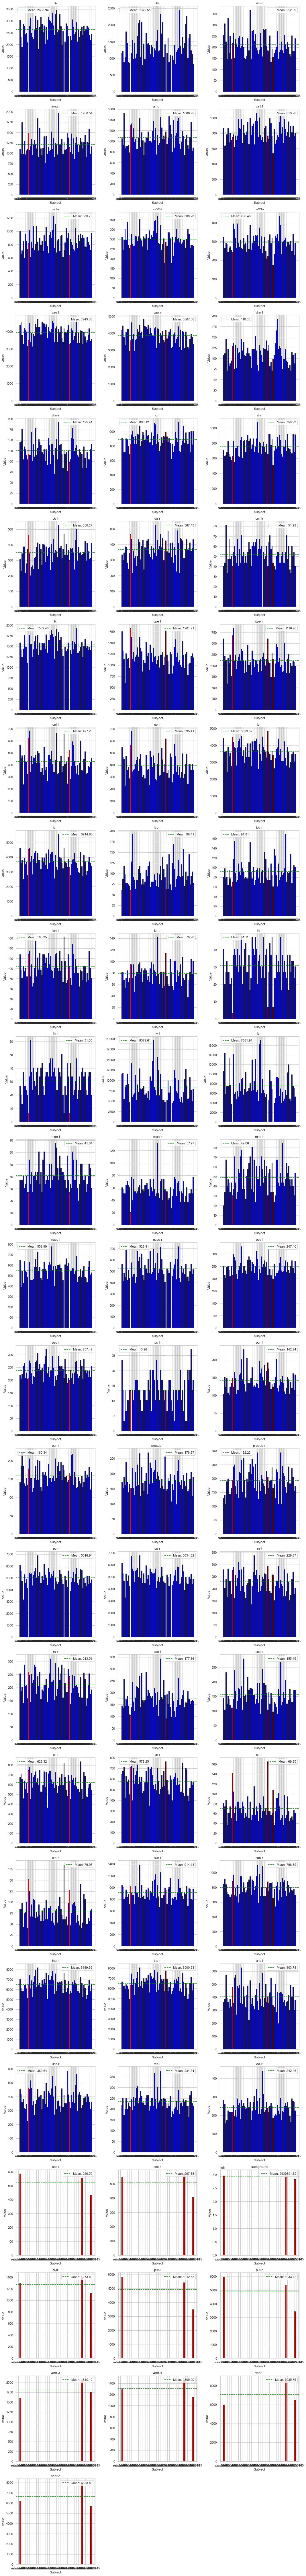

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_roi_distributions(df, highlight_rows=['sub-066','sub-069','sub-075']):
    # Extract subject index
    subjects = df.index
    
    # Extract ROI columns
    rois = df.columns  # Include all columns for ROI
    
    num_rois = len(rois)
    num_cols = 3  # Number of columns in the grid
    num_rows = (num_rois + num_cols - 1) // num_cols  # Calculate number of rows needed

    # Set up the matplotlib figure
    plt.figure(figsize=(5 * num_cols, 5 * num_rows))
    
    for i, roi in enumerate(rois):
        plt.subplot(num_rows, num_cols, i + 1)
        
        # Extract values for the current ROI
        roi_values = df[roi]
        
        # Define colors based on row names
        colors = ['red' if subject in highlight_rows else 'blue' for subject in subjects]
        
        # Create bar plot
        plt.bar(subjects, roi_values, color=colors, edgecolor='k')
        
        # Add horizontal line for the mean value
        mean_value = roi_values.mean()
        plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
        
        plt.xlabel('Subject')
        plt.ylabel('Value')
        plt.title(roi)  # Add the column name as the title
        plt.legend()  # Show legend to indicate the mean line
    
    plt.tight_layout()
    plt.show()

# Call the function with your DataFrame
plot_roi_distributions(df)

In [28]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# def plot_roi_distributions(df, highlight_rows=['sub-066','sub-069','sub-075'], pdf_filename='ROIs_sizes.pdf'):
#     # Extract subject index
#     subjects = df.index
    
#     # Extract ROI columns
#     rois = df.columns  # Include all columns for ROI
    
#     num_rois = len(rois)
#     num_cols = 3  # Number of columns in the grid
#     num_rows = (num_rois + num_cols - 1) // num_cols  # Calculate number of rows needed

#     with PdfPages(pdf_filename) as pdf:
#         for i, roi in enumerate(rois):
#             plt.figure(figsize=(5 * num_cols, 5 * num_rows))
#             plt.subplot(num_rows, num_cols, i + 1)
            
#             # Extract values for the current ROI
#             roi_values = df[roi]
            
#             # Define colors based on row names
#             colors = ['red' if subject in highlight_rows else 'blue' for subject in subjects]
            
#             # Create bar plot
#             plt.bar(subjects, roi_values, color=colors, edgecolor='k')
            
#             # Add horizontal line for the mean value
#             mean_value = roi_values.mean()
#             plt.axhline(mean_value, color='green', linestyle='--', linewidth=1.5, label=f'Mean: {mean_value:.2f}')
            
#             plt.xlabel('Subject')
#             plt.ylabel('Value')
#             plt.title(roi)  # Add the column name as the title
#             plt.legend()  # Show legend to indicate the mean line
            
#             # Save the current figure to the PDF
#             pdf.savefig()
#             plt.close()

# # Example usage with DataFrame and highlight rows
# # df = pd.DataFrame({
# #     'Subject': ['Subject1', 'Subject2', 'Subject3'],
# #     'ROI1': [1.0, 2.0, 1.5],
# #     'ROI2': [2.5, 1.5, 2.0]
# # })
# # df.set_index('Subject', inplace=True)
# # highlight_rows = ['Subject1', 'Subject3']  # List of subjects to highlight
# # pdf_filename = 'roi_distributions.pdf'
# # plot_roi_distributions(df, highlight_rows, pdf_filename)
# plot_roi_distributions(df)

### rsFC informed masks on group level to subject level with inverse transformation matrix

In [14]:
# ## Create folders as antsApplyTransform seem to not create them
source_dir = "/home/Public/trondheim/derivatives/rs-midbrain/0_data/rs-residuals/smooth_1p5mm/mni/hp"
target_dir = "/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func" 
folders = [folder for folder in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, folder))]

for folder in folders:
    rs_subs = folder[-3:]

    sub_dir = os.path.join(target_dir, f"sub-{rs_subs}")
    os.makedirs(sub_dir, exist_ok=True)  

    anat_dir = os.path.join(sub_dir, 'anat')
    os.makedirs(anat_dir, exist_ok=True)  

print("Directory structure created successfully.")


In [2]:
import subprocess
import os
import glob
# from MNI to T1w with the before used transformation M
def apply_inverse_transform(sub, mni_image, t1w_image, output_image): 
    warp_file = f"/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/anat/sub-{sub}_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5"
                                                                                      
    
    cmd = [
        "antsApplyTransforms",
        "-d", "3",
        "-i", mni_image,
        "-r", t1w_image,
        "-t", warp_file,  
        "-o", output_image
    ]
    
    try:
        subprocess.run(cmd, check=True)
        print(f"Inverse transformation completed for subject {sub}. Output saved to {output_image}")
    except subprocess.CalledProcessError as e:
        print(f"Error during inverse transformation for subject {sub}: {e}")

N73_subjects = [os.path.basename(f).split('_')[2] for f in glob.glob('/home/Public/trondheim/derivatives/rs-midbrain/0_data/rs-residuals/smooth_1p5mm/mni/hp/_sub*')]

# mni_images = {
#     "DopMidbrain": ["normalized_IC0.nii.gz", "normalized_IC5.nii.gz"],
#     "VTA": ["normalized_IC2.nii.gz", "normalized_IC6.nii.gz", "normalized_IC7.nii.gz"],
#     "Str": ["normalized_IC0.nii.gz", "normalized_IC3.nii.gz", "normalized_IC6.nii.gz"]
# }

# for sub in N73_subjects:
#     for component, images in mni_images.items():
#         for mni_image in images:
#             # mni_image_path = f"/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/{component}/{mni_image}}"
#             mni_image_path = f"/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/{component}/normalized/{mni_image}"
#             t1w_image_path = f"/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/ses-anatomical/func/sub-{sub}_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz"
#             output_image_path = f"/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{component}_IC{mni_image.split('_')[-1][2]}.nii.gz"
#             # output_image_path = f"/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{mni_image}.nii.gz"

#             apply_inverse_transform(sub, mni_image_path, t1w_image_path, output_image_path)


### in folder rs-IC_map
mni_images = {
    "DopMidbrain": ["IC0_thres-60.nii.gz", "IC5_thres-60.nii.gz"],
    "VTA": ["IC2_thres-60.nii.gz", "IC6_thres-60.nii.gz", "IC7_thres-60.nii.gz"],
     "Str": ["IC0_thres-60.nii.gz", "IC3_thres-60.nii.gz", "IC6_thres-60.nii.gz"]

}

for sub in N73_subjects:
    for component, images in mni_images.items():
        for mni_image in images:
            mni_image_path = f"/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/{component}/rs-IC_map/{mni_image}"
            t1w_image_path = f"/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/ses-anatomical/func/sub-{sub}_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz"
            # don't forget to adjust
            output_image_path = f"/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{component}_{mni_image}"

            apply_inverse_transform(sub, mni_image_path, t1w_image_path, output_image_path)



Inverse transformation completed for subject 034. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-034/anat/sub-034_space-T1w_desc-mask-DopMidbrain_IC0_thres-60.nii.gz
Inverse transformation completed for subject 034. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-034/anat/sub-034_space-T1w_desc-mask-DopMidbrain_IC5_thres-60.nii.gz
Inverse transformation completed for subject 034. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-034/anat/sub-034_space-T1w_desc-mask-VTA_IC2_thres-60.nii.gz
Inverse transformation completed for subject 034. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-034/anat/sub-034_space-T1w_desc-mask-VTA_IC6_thres-60.nii.gz
Inverse transformation completed for subject 034. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-034/anat/sub-034_space-T1w_desc-mas

Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5


Error during inverse transformation for subject 022: Command '['antsApplyTransforms', '-d', '3', '-i', '/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/DopMidbrain/rs-IC_map/IC5_thres-60.nii.gz', '-r', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/ses-anatomical/func/sub-022_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '-t', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5', '-o', '/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-022/anat/sub-022_space-T1w_desc-mask-DopMidbrain_IC5_thres-60.nii.gz']' returned non-zero exit status 1.
Error during inverse transformation for subject 022: Command '['antsApplyTransforms', '-d', '3', '-i', '/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/VTA/rs-IC_map/IC2_thres-60.nii.gz', '-r', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/ses-anatomical/func/sub-022_ses-anatomical_tas

Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5


Error during inverse transformation for subject 022: Command '['antsApplyTransforms', '-d', '3', '-i', '/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/Str/rs-IC_map/IC3_thres-60.nii.gz', '-r', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/ses-anatomical/func/sub-022_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz', '-t', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5', '-o', '/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func_thres-60/sub-022/anat/sub-022_space-T1w_desc-mask-Str_IC3_thres-60.nii.gz']' returned non-zero exit status 1.
Error during inverse transformation for subject 022: Command '['antsApplyTransforms', '-d', '3', '-i', '/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/Str/rs-IC_map/IC6_thres-60.nii.gz', '-r', '/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/ses-anatomical/func/sub-022_ses-anatomical_task-rs_run-1_space

Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
Transform file does not exist: /home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-022/anat/sub-022_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5
### sub-022 only ses-anatomical folder, within that anat, and warp_file has different name
#### On the other hand, no behav/fMRI revl sessions for subj-022, only relevant to rsFC 


In [10]:
# import os
# import glob
# import subprocess

# sub = "022" 

# mni_images = {
#     "DopMidbrain": ["normalized_IC0.nii.gz", "normalized_IC5.nii.gz"],
#     "VTA": ["normalized_IC2.nii.gz", "normalized_IC6.nii.gz", "normalized_IC7.nii.gz"],
#     "Str": ["normalized_IC0.nii.gz", "normalized_IC3.nii.gz", "normalized_IC6.nii.gz"]
# }

# for component, images in mni_images.items():
#     for mni_image in images:
#         mni_image_path = f"/home/Public/trondheim/derivatives/rs-midbrain/1_ICA/rs-echoes/{component}/normalized/{mni_image}"
#         t1w_image_path = f"/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/ses-anatomical/func/sub-{sub}_ses-anatomical_task-rs_run-1_space-T1w_boldref.nii.gz"
#         output_image_path = f"/home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-{sub}/anat/sub-{sub}_space-T1w_desc-mask-{component}_IC{mni_image.split('_')[-1][2]}.nii.gz"
#         warp_file_022 = f"/home/Public/trondheim/derivatives/fmriprep/fmriprep/sub-{sub}/ses-anatomical/anat/sub-{sub}_ses-anatomical_from-MNI152NLin2009cAsym_to-T1w_mode-image_xfm.h5"
        
#         cmd = [
#             "antsApplyTransforms",
#             "-d", "3",
#             "-i", mni_image_path,
#             "-r", t1w_image_path,
#             "-t", warp_file_022,  
#             "-o", output_image_path
#         ]
        
#         try:
#             subprocess.run(cmd, check=True)
#             print(f"Inverse transformation completed for subject {sub}. Output saved to {output_image_path}")
#         except subprocess.CalledProcessError as e:
#             print(f"Error during inverse transformation for subject {sub}: {e}")



Inverse transformation completed for subject 022. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-022/anat/sub-022_space-T1w_desc-mask-DopMidbrain_IC0.nii.gz
Inverse transformation completed for subject 022. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-022/anat/sub-022_space-T1w_desc-mask-DopMidbrain_IC5.nii.gz
Inverse transformation completed for subject 022. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-022/anat/sub-022_space-T1w_desc-mask-VTA_IC2.nii.gz
Inverse transformation completed for subject 022. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-022/anat/sub-022_space-T1w_desc-mask-VTA_IC6.nii.gz
Inverse transformation completed for subject 022. Output saved to /home/Public/trondheim/derivatives/masks_rsFC_MB_VTA_Str_func/sub-022/anat/sub-022_space-T1w_desc-mask-VTA_IC7.nii.gz
Inverse transformation completed for subject 022. Output saved t